In [1]:
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import time
from numpy import expand_dims
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.metrics import accuracy_score
import keras
import numpy as np
import os
import time

In [2]:
def import_images(directory,size = (480,640)):
    images = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        img = cv2.imread(f)
        img = cv2.resize(img,size)
        img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_norm = img_RGB/255
        images.append(img_norm)
    return np.array(images)    

In [3]:
empty = import_images(r"C:\Users\DELL\Desktop\face_recognition\empty")
not_empty = import_images(r"C:\Users\DELL\Desktop\face_recognition\not_empty")

In [4]:
me_datagen = ImageDataGenerator( rotation_range = 30, zoom_range = 0.20, 
fill_mode = "nearest", shear_range = 0.20, horizontal_flip = True, 
width_shift_range = 0.1, height_shift_range = 0.1)

In [5]:
def image_augmentation(train_dir,test_dir,dataset_size,tr_ts_split,numb_of_images,images):
    naming_var = 0
    loop_range = dataset_size/numb_of_images
    train_treshold = loop_range*tr_ts_split
    for i in images:
        naming_var += 1
        sample = expand_dims(i, 0)
        generator = me_datagen.flow(sample, batch_size=1)
        for j in range(int(loop_range)):
            imgn = generator.next()
            imgn_RGB = cv2.cvtColor(imgn[0], cv2.COLOR_BGR2RGB)
            name = str(naming_var) + "_" + str(j)+".jpg"
            if j < train_treshold:
                cv2.imwrite(train_dir + "\img_" + name, 255*imgn_RGB)
            else:
                cv2.imwrite(test_dir + "\img_" + name, 255*imgn_RGB)

In [34]:
image_augmentation(r"C:\Users\DELL\Desktop\root\train\empty",r"C:\Users\DELL\Desktop\root\test\empty",
                  1000,0.8,10,empty)

In [35]:
image_augmentation(r"C:\Users\DELL\Desktop\root\train\not_empty",r"C:\Users\DELL\Desktop\root\test\not_empty",
                  1000,0.8,10,not_empty)

In [6]:
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(r"C:\Users\DELL\Desktop\root\train",target_size=(480,640),
class_mode="binary",batch_size=10,shuffle=True)
test_generator = datagen.flow_from_directory(r"C:\Users\DELL\Desktop\root\test",target_size=(480,640),
class_mode="binary",batch_size=10)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [7]:
class StopOnPoint(tf.keras.callbacks.Callback):
    def _init_(self):
        super(StopOnPoint,self)._init_()
        #self.point = point
        
    def on_epoch_end(self, epoch, logs =None):
        accuracy = logs["accuracy"]
        val_accuracy = logs["val_accuracy"]
        if accuracy >= 0.98 and val_accuracy >= 0.98:
            self.model.stop_training = True

In [9]:
model = Sequential()
model.add(Conv2D(32,(3,3),activation="relu",input_shape=(480,640, 3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32,(3,3),activation="relu"))
model.add(Flatten())
model.add(Dense(64,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(32,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10,activation="relu"))
model.add(Dense(1,activation="sigmoid"))
opt = RMSprop()
SOP = StopOnPoint()
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])
fit = model.fit_generator(train_generator,validation_data=test_generator,steps_per_epoch = 160,validation_steps=40,epochs=100,callbacks=[SOP])

<ipython-input-9-93a4a9325d82>:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit = model.fit_generator(train_generator,validation_data=test_generator,steps_per_epoch = 160,validation_steps=40,epochs=100,callbacks=[SOP])


Epoch 1/100
160/160 [==============================] - 879s 5s/step - loss: 0.9809 - accuracy: 0.5106 - val_loss: 0.4812 - val_accuracy: 0.6900
Epoch 2/100
160/160 [==============================] - 1012s 6s/step - loss: 0.5558 - accuracy: 0.7513 - val_loss: 0.4457 - val_accuracy: 0.8525
Epoch 3/100
160/160 [==============================] - 1064s 7s/step - loss: 0.5074 - accuracy: 0.8225 - val_loss: 0.4652 - val_accuracy: 0.7925
Epoch 4/100
160/160 [==============================] - 4259s 27s/step - loss: 0.4885 - accuracy: 0.8238 - val_loss: 0.3085 - val_accuracy: 0.8750
Epoch 5/100
160/160 [==============================] - 2621s 16s/step - loss: 0.4760 - accuracy: 0.8587 - val_loss: 0.3101 - val_accuracy: 0.8750
Epoch 6/100
160/160 [==============================] - 642s 4s/step - loss: 0.3135 - accuracy: 0.9319 - val_loss: 0.4140 - val_accuracy: 0.9375
Epoch 7/100
160/160 [==============================] - 4490s 28s/step - loss: 0.2917 - accuracy: 0.9669 - val_loss: 0.0826 - val_a

No handles with labels found to put in legend.


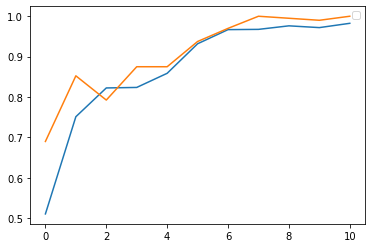

In [10]:
plt.plot(fit.history['accuracy'])
plt.plot(fit.history['val_accuracy'])
plt.legend()

In [11]:
model.save('inv_classifier')

INFO:tensorflow:Assets written to: inv_classifier\assets


In [3]:
model = keras.models.load_model("inv_classifier")

In [28]:
val_data = import_images(r"C:\Users\DELL\Desktop\face_recognition\not_empty",size=(640,480))

In [30]:
model.predict(val_data) > 0.5

array([[False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

In [18]:
model.save(r'C:\Users\DELL\Desktop\env_classifier')

INFO:tensorflow:Assets written to: C:\Users\DELL\Desktop\env_classifier\assets
